In [1]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np
import uproot
import os
import glob
import awkward as ak
from scipy.stats import norm

In [2]:
data_path = "/home/haue/repositories/Masters/data/singleprotons/Al/inclbetacut/"
g_singlep_path = "/home/haue/repositories/Masters/data/gamma/Al/withbeta"

#outputdir = "/figure_output/"
## Load in all files from the datapath with the suffix mlio.root
Al_files = glob.glob(os.path.join(data_path, "*mlio.root"))
g_singlep_files = glob.glob(os.path.join(g_singlep_path, "*mlio.root"))

#Files to be analyzed 
Analysis_files = g_singlep_files

upscale = 1/0.34
scale =  4.993289447838043 # ratio between total solid angle coverage and solid angle coverage of id3 to account for lack of detection of beta particles

In [51]:

Egs1_b = np.array([]);Egs2_b = np.array([])
Egs1_b_eff = np.array([]);Egs2_b_eff = np.array([])        
for batch in uproot.iterate(Analysis_files, expressions=["Eg1", "eff1"],
            cut=f"(pg1) & (Eg1>0) & (eff1>0)"):
    Egs1_b = np.append(Egs1_b, batch.Eg1)
    Egs1_b_eff = np.append(Egs1_b_eff, batch.eff1)
print("Eg1 done")
for batch in uproot.iterate(Analysis_files, expressions=["Eg2", "eff2"],
            cut=f"(pg2) & (Eg2>0) & (eff2>0)"):
    Egs2_b = np.append(Egs2_b, batch.Eg2)
    Egs2_b_eff = np.append(Egs2_b_eff, batch.eff2)

Egs1_b = Egs1_b[~np.isnan(Egs1_b)]
Egs2_b = Egs2_b[~np.isnan(Egs2_b)]
Egs1_b_eff = Egs1_b_eff[~np.isnan(Egs1_b_eff)]
Egs2_b_eff = Egs2_b_eff[~np.isnan(Egs2_b_eff)]

Eg1 done


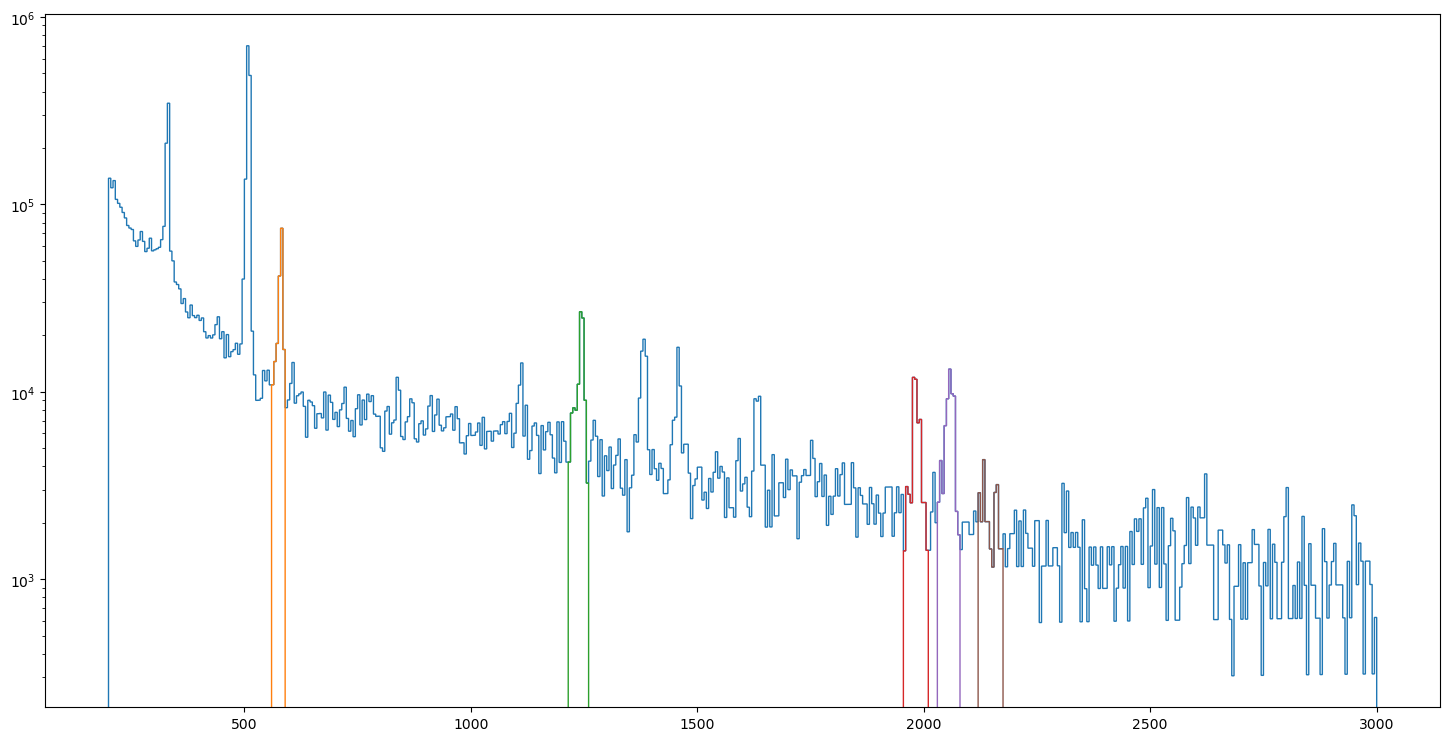

In [16]:
plt.figure(figsize=(18,9))
lowlims = [560,1215,1955,2030,2120]
uplims = [590,1260,2010,2080,2175]

plt.hist(Egs1_b, bins=np.arange(200,3000+5, 5),weights=1/np.array(Egs1_b_eff), histtype='step')
for l,u in zip(lowlims,uplims):
    mask = (Egs1_b < u) & (Egs1_b>l)
    plt.hist(Egs1_b[mask], bins=np.arange(200,3000+5,5), weights=1/np.array(Egs1_b_eff[mask]), histtype='step')
plt.yscale('log')

In [17]:
from scipy.special import erfc

def expgausslin(x, A, mu, sigma, lamb,s,c):
    x = np.asarray(x)
    arg1 = lamb / 2 * (2 * mu + lamb * sigma**2 - 2 * x)
    arg2 = (mu + lamb * sigma**2 - x) / (np.sqrt(2) * sigma)
    emg = A * (lamb / 2) * np.exp(arg1) * erfc(arg2)
    b = s*x+c
    return emg+b
def gausslin(x, a, x0, sigma, s, c):
    return a*np.exp(-(x-x0)**2/(2*sigma**2)) + s*x+c
def gauss(x, A, mu, sigma):
    return A * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))


Area under Gaussian: 540019.15 ± 26411.42 counts
Fit parameters: 69188.71216567681 581.2260994435132 3.1137517340909624


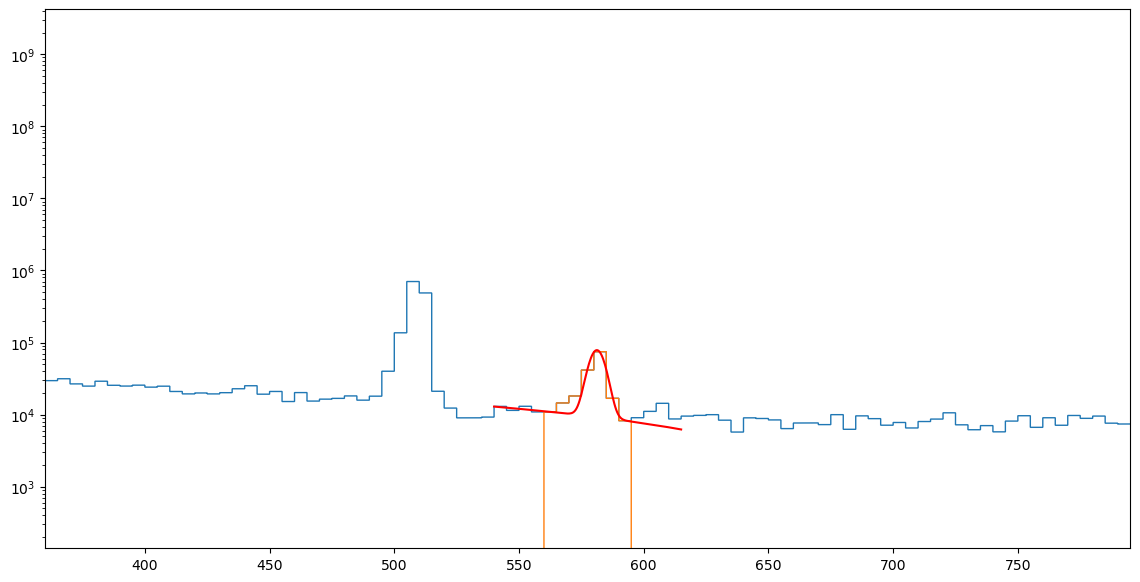

Area under Gaussian: 296742.96 ± 22061.94 counts
Fit parameters: 25199.45229192817 1244.4916510044584 4.697852623391577


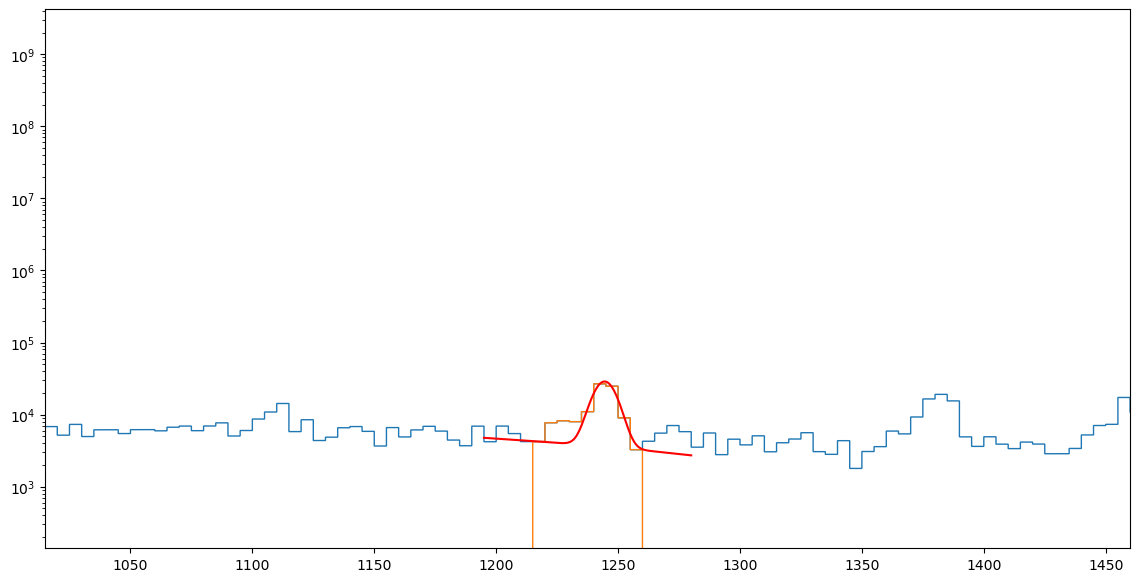

Area under Gaussian: 161212.65 ± 17516.53 counts
Fit parameters: 9168.216170358834 1983.4024787287576 7.014946217756965


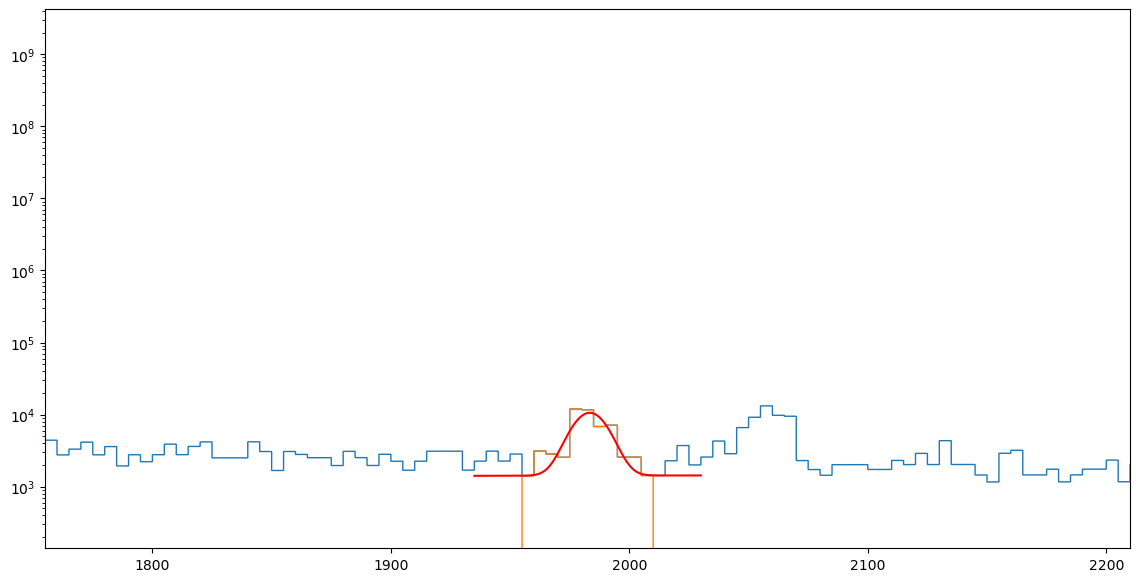

Area under Gaussian: 189663.33 ± 19892.80 counts
Fit parameters: 10657.649410435732 2058.188400641637 7.099569195683995


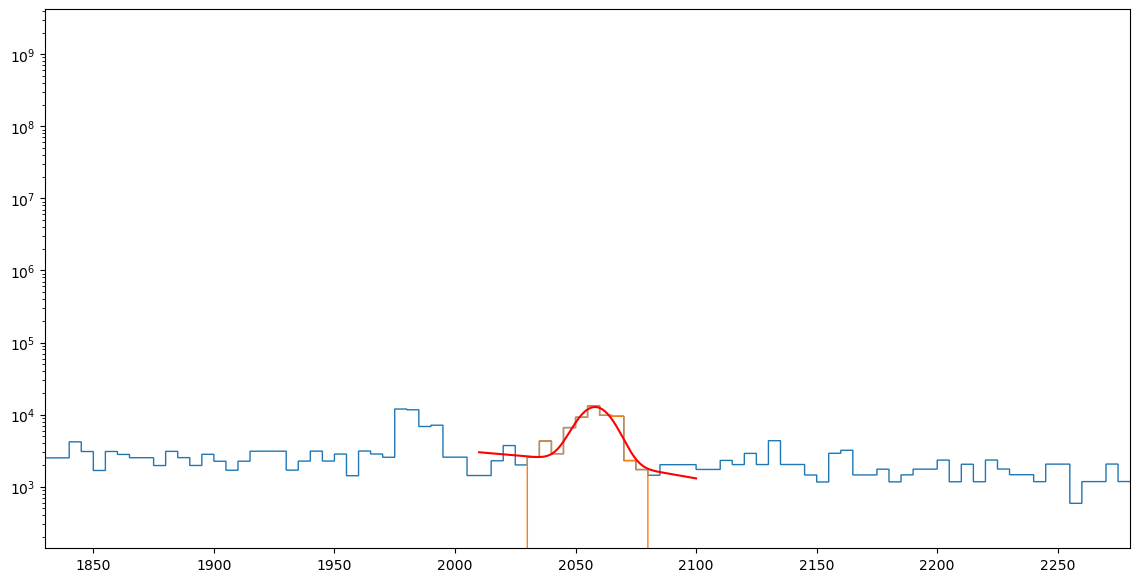

'\nu = 1660\nl = 1610\nplt.figure(figsize=(14,7))\nplt.hist(e, bins=np.arange(0,3000+5, 5),weights=1/np.array(e_eff)*scale, histtype=\'step\')\nmask = (e < u) & (e>l)\nplt.hist(e[mask], bins=np.arange(0,3000+5,5),weights=1/np.array(e_eff[mask])*scale, histtype=\'step\')\nplt.yscale(\'log\')\n#plt.ylim(0,25)\nplt.xlim(l-200,u+200)\n\nys, xs = np.histogram(e[mask], bins=np.arange(l, u+5,5),weights=1/np.array(e_eff)[mask])\nys_var, _ = np.histogram(e[mask], bins=np.arange(l, u+5,5), weights=1/np.array(e_eff)[mask]**2)\nxs = np.array(xs[:-1])+5/2\nys_err = np.sqrt(ys_var)*scale\nys = np.array(ys)*scale\n\nx_bg = np.concatenate(((xs[:1]+xs[1:2])/2, xs[-1:]))\ny_bg = np.concatenate(((ys[:1]+ys[1:2])/2, ys[-1:]))\n\ns_fit, c_fit = np.polyfit(x_bg, y_bg, 1)\n\nfunc_fixed_bg = lambda x, a, x0, sigma: gausslin(x, a, x0, sigma, s_fit, c_fit)\n\na_guess = np.max(ys)\nx0_guess = xs[np.argmax(ys)]\nsigma_guess = 10\np0_final = [a_guess, x0_guess, sigma_guess]\n\n\npopt, pcov = curve_fit(func_fixed_b

In [54]:
lowlims = [560,1215,1955,2030]
uplims = [595,1260,2010,2080]

areas1 =  []
areas1_err = []

e = Egs1_b
e_eff = Egs1_b_eff


for l,u in zip(lowlims,uplims):
    plt.figure(figsize=(14,7))
    plt.hist(e, bins=np.arange(0,3000+5, 5),weights=1/np.array(e_eff), histtype='step')
    
    mask = (e < u) & (e>l)
    plt.hist(e[mask], bins=np.arange(0,3000+5,5),weights=1/np.array(e_eff)[mask], histtype='step')
    plt.yscale('log')
    plt.xlim(l-200,u+200)
    
    ys, xs = np.histogram(e[mask], bins=np.arange(l, u+5,5),weights=1/np.array(e_eff)[mask])
    ys_var, _ = np.histogram(e[mask], bins=np.arange(l, u+5,5), weights=1/np.array(e_eff)[mask]**2)
    xs = np.array(xs[:-1])+5/2
    ys_err = np.sqrt(ys_var)
    ys = np.array(ys) 

    
    x_bg = np.concatenate((xs[:1], xs[-1:]))
    y_bg = np.concatenate((ys[:1], ys[-1:]))

    s_fit, c_fit = np.polyfit(x_bg, y_bg, 1)

    func_fixed_bg = lambda x, a, x0, sigma: gausslin(x, a, x0, sigma, s_fit, c_fit)

    a_guess = np.max(ys)
    x0_guess = xs[np.argmax(ys)]
    sigma_guess = 10
    p0_final = [a_guess, x0_guess, sigma_guess]

    #errors = np.sqrt(ys)
    #errors[ys == 0] = np.inf

    popt, pcov = curve_fit(func_fixed_bg,xs,ys,p0=p0_final,sigma=ys_err, absolute_sigma=True)

    final_parameters = [popt[0], popt[1], popt[2], s_fit, c_fit]
    
    xlin = np.linspace(l-20, u+20, 200)
    yfit = gausslin(xlin, *final_parameters)
    area = popt[0] * popt[2] * np.sqrt(2 * np.pi)
    #area_err = np.sqrt(area)
    area_err = np.sqrt(
    (popt[2]**2 * 2 * np.pi * pcov[0, 0]) +
    (popt[0]**2 * 2 * np.pi * pcov[2, 2]) +
    (2 * popt[0] * popt[2] * 2 * np.pi * pcov[0, 2])
)
    print(f"Area under Gaussian: {area:.2f} ± {area_err:.2f} counts")

    plt.plot(xlin, yfit, label="expgauss fit", color='r')
    print("Fit parameters:", *popt)
    areas1.append(area)
    areas1_err.append(area_err)
    plt.show()

#####################################################################################################################################################################################
"""
u = 1660
l = 1610
plt.figure(figsize=(14,7))
plt.hist(e, bins=np.arange(0,3000+5, 5),weights=1/np.array(e_eff)*scale, histtype='step')
mask = (e < u) & (e>l)
plt.hist(e[mask], bins=np.arange(0,3000+5,5),weights=1/np.array(e_eff[mask])*scale, histtype='step')
plt.yscale('log')
#plt.ylim(0,25)
plt.xlim(l-200,u+200)

ys, xs = np.histogram(e[mask], bins=np.arange(l, u+5,5),weights=1/np.array(e_eff)[mask])
ys_var, _ = np.histogram(e[mask], bins=np.arange(l, u+5,5), weights=1/np.array(e_eff)[mask]**2)
xs = np.array(xs[:-1])+5/2
ys_err = np.sqrt(ys_var)*scale
ys = np.array(ys)*scale

x_bg = np.concatenate(((xs[:1]+xs[1:2])/2, xs[-1:]))
y_bg = np.concatenate(((ys[:1]+ys[1:2])/2, ys[-1:]))

s_fit, c_fit = np.polyfit(x_bg, y_bg, 1)

func_fixed_bg = lambda x, a, x0, sigma: gausslin(x, a, x0, sigma, s_fit, c_fit)

a_guess = np.max(ys)
x0_guess = xs[np.argmax(ys)]
sigma_guess = 10
p0_final = [a_guess, x0_guess, sigma_guess]


popt, pcov = curve_fit(func_fixed_bg,xs,ys,p0=p0_final,sigma=ys_err,absolute_sigma=True)

final_parameters = [popt[0], popt[1], popt[2], s_fit, c_fit]
xlin = np.linspace(l-20, u+20, 200)
yfit = gausslin(xlin, *final_parameters)
area = popt[0] * popt[2] * np.sqrt(2 * np.pi)
perr = np.sqrt(np.diag(pcov))
area_err = np.sqrt(
    (popt[2]**2 * 2 * np.pi * pcov[0, 0]) +
    (popt[0]**2 * 2 * np.pi * pcov[2, 2]) +
    (2 * popt[0] * popt[2] * 2 * np.pi * pcov[0, 2])
)
print(f"Area under Gaussian: {area:.2f} ± {area_err:.2f} counts")

plt.plot(xlin, yfit, label="expgauss fit", color='r')
print("Fit parameters:", *popt)
areas1.append(area)
areas1_err.append(area_err)
plt.show()
#####################################################################################################################################################################################

u = 1620
l = 1575
bw = 5
plt.figure(figsize=(14,7))
plt.hist(e, bins=np.arange(0,3000+bw, bw),weights=1/np.array(e_eff)*scale, histtype='step')
mask = (e < u) & (e>l)
plt.hist(e[mask], bins=np.arange(0,3000+bw,bw),weights=1/np.array(e_eff)[mask]*scale, histtype='step')
plt.yscale('log')
#plt.ylim(0,25)
plt.xlim(l-200,u+200)
ys, xs = np.histogram(e[mask], bins=np.arange(l, u+bw,bw),weights=1/np.array(e_eff)[mask])
ys_var, _ = np.histogram(e[mask], bins=np.arange(l, u+bw,bw), weights=1/np.array(e_eff)[mask]**2)
xs = np.array(xs[:-1])+bw/2
ys_err = np.sqrt(ys_var)*scale
ys = np.array(ys)*scale

lowmask = (e<1575) & (e>1500)
upmask = (e<1700) & (e>1650)
ylow, _ = np.histogram(e[lowmask], bins=np.arange(1500, 1575+bw,bw),weights=1/np.array(e_eff)[lowmask])
yup, _ = np.histogram(e[upmask], bins=np.arange(1650, 1700+bw,bw),weights=1/np.array(e_eff)[upmask])
x_bg = np.concatenate((xs[:1], xs[-1:]))
y_bg = [np.mean(ylow), np.mean(yup)]

s_fit, c_fit = np.polyfit(x_bg, y_bg, 1)

func_fixed_bg = lambda x, a, x0, sigma: gausslin(x, a, x0, sigma, s_fit, c_fit)

a_guess = np.max(ys)
x0_guess = xs[np.argmax(ys)]
sigma_guess = 10
p0_final = [a_guess, x0_guess, sigma_guess]

errors = np.sqrt(ys_var)

popt, pcov = curve_fit(func_fixed_bg,xs,ys,p0=p0_final,sigma=errors, absolute_sigma=True)

final_parameters = [popt[0], popt[1], popt[2], s_fit, c_fit]
xlin = np.linspace(l-20, u+20, 200)
yfit = gausslin(xlin, *final_parameters)
area = popt[0] * popt[2] * np.sqrt(2 * np.pi)
perr = np.sqrt(np.diag(pcov))
area_err = np.sqrt(
    (popt[2]**2 * 2 * np.pi * pcov[0, 0]) +
    (popt[0]**2 * 2 * np.pi * pcov[2, 2]) +
    (2 * popt[0] * popt[2] * 2 * np.pi * pcov[0, 2])
)
print(f"Area under Gaussian: {area:.2f} ± {area_err:.2f} counts")

plt.plot(xlin, yfit, label="expgauss fit", color='r')
print("Fit parameters:", *popt)
areas1.append(area)
areas1_err.append(area_err)
plt.show()
"""

In [60]:
def G1eff(E):
    A = -1.23
    B = 6.4e-2
    C = 1.2e7
    ln_e_value = A * np.log(E) + B * np.log(E)**2 - C / E**3
    return np.exp(ln_e_value)

def G2eff(E):
    A = 0.138
    B = -0.5
    return A * E**(B)



#Area under Gaussian: 419.97 ± 50.42 counts
#Fit parameters: 36.91180318122375 580.6787236053268 4.539044013197144

36.9118/G1eff(580.6787) * 4.5390* np.sqrt(2 * np.pi), 100/6.7*42000, 540019+626865, 540019/(540019+626865)*100, 626865/(540019+626865) *100


(83887.7276056481,
 626865.671641791,
 1166884,
 46.27872179239753,
 53.721278207602474)

In [55]:
for a,e in zip(areas1,areas1_err):
    print(f"area: {a:.0f} +/- {e:.0f} - ({e/a*100})")
#areas, areas_err
totc = sum(areas1[1:])

totc_e = np.sqrt(np.sum(np.array(areas1_err[1:-1])**2))
def rel(c, c_e):
    br = (c/totc) *100
    br_e = br*np.sqrt((c_e/c)**2+(totc_e/totc)**2)
    return br,br_e
for i in range(0,4):
    print(rel(areas1[i], areas1_err[i]))

area: 540019 +/- 26411 - (4.890830985894777)
area: 296743 +/- 22062 - (7.434696443100456)
area: 161213 +/- 17517 - (10.865479912978968)
area: 189663 +/- 19893 - (10.488479118785788)
(83.38532458493931, 5.457824573500583)
(45.82061185309775, 3.9468416692515316)
(24.893134438761553, 2.913448208548248)
(29.28625370814069, 3.3253634614735934)


Area under Gaussian: 529968.15 ± 24130.22 counts
Fit parameters: 73317.4941373448 581.3282372178442 2.883714248694808


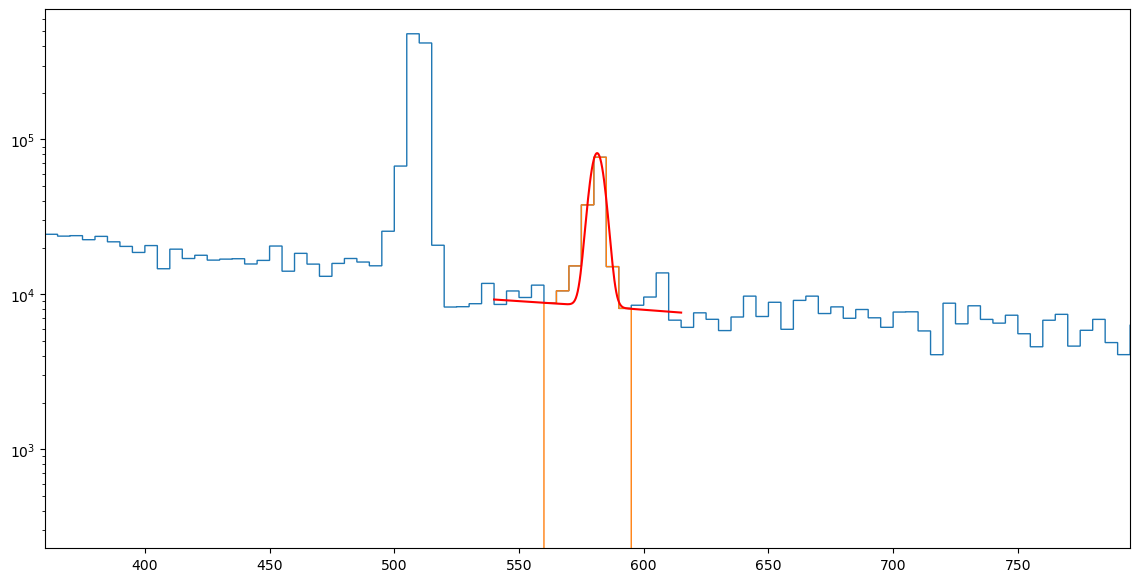

Area under Gaussian: 363951.07 ± 23713.40 counts
Fit parameters: 31541.509534773726 1244.0668179718484 4.603313901569188


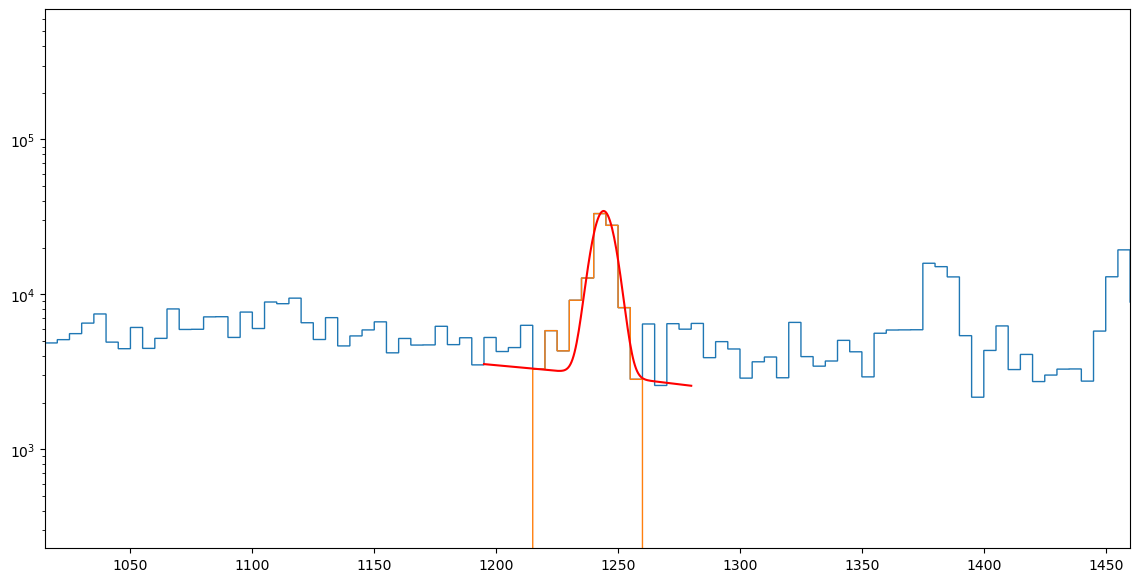

Area under Gaussian: 127297.20 ± 18782.65 counts
Fit parameters: 9918.200242523599 1981.646410831982 5.120307668662651


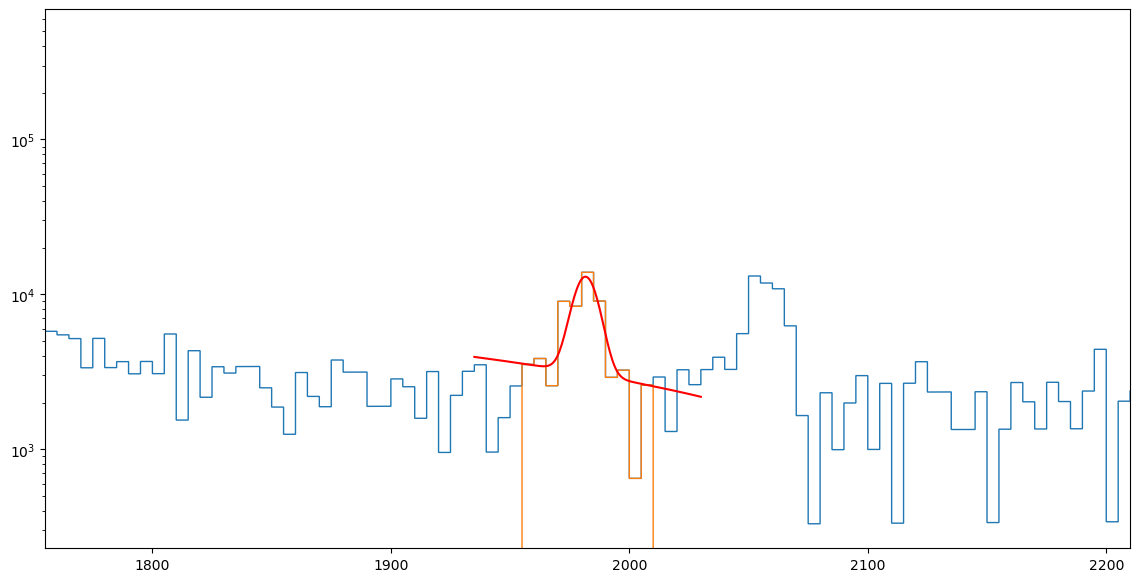

Area under Gaussian: 160825.64 ± 20689.72 counts
Fit parameters: 11264.261802322471 2056.9258355801067 5.695903305299346


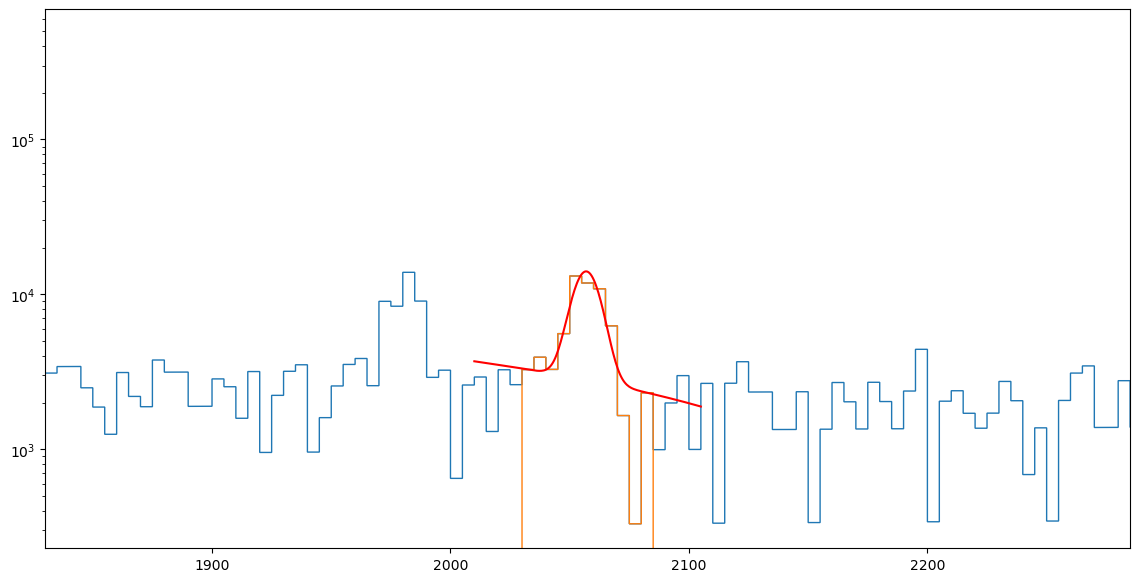

Area under Gaussian: 23583.61 ± 8972.61 counts
Fit parameters: 2717.762159066205 2122.77808123321 3.4618551862592652


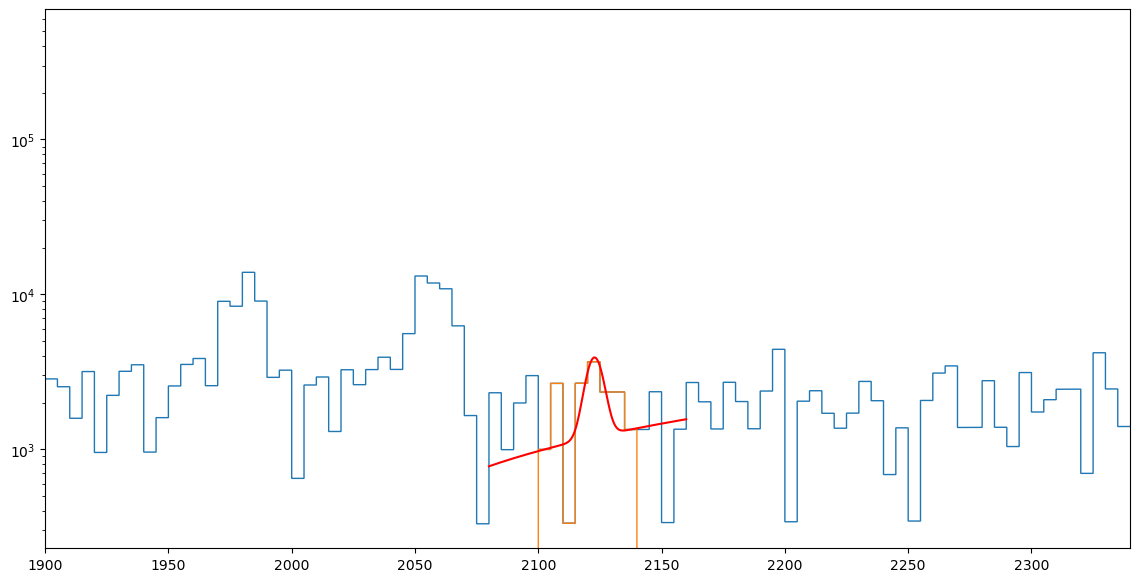

'\nu = 1660\nl = 1610\nplt.figure(figsize=(14,7))\nplt.hist(e, bins=np.arange(0,3000+5, 5),weights=1/np.array(e_eff)*scale, histtype=\'step\')\nmask = (e < u) & (e>l)\nplt.hist(e[mask], bins=np.arange(0,3000+5,5),weights=1/np.array(e_eff[mask])*scale, histtype=\'step\')\nplt.yscale(\'log\')\n#plt.ylim(0,25)\nplt.xlim(l-200,u+200)\n\nys, xs = np.histogram(e[mask], bins=np.arange(l, u+5,5),weights=1/np.array(e_eff)[mask])\nys_var, _ = np.histogram(e[mask], bins=np.arange(l, u+5,5), weights=1/np.array(e_eff)[mask]**2)\nxs = np.array(xs[:-1])+5/2\nys_err = np.sqrt(ys_var)*scale\nys = np.array(ys)*scale\n\nx_bg = np.concatenate(((xs[:1]+xs[1:2])/2, xs[-1:]))\ny_bg = np.concatenate(((ys[:1]+ys[1:2])/2, ys[-1:]))\n\ns_fit, c_fit = np.polyfit(x_bg, y_bg, 1)\n\nfunc_fixed_bg = lambda x, a, x0, sigma: gausslin(x, a, x0, sigma, s_fit, c_fit)\n\na_guess = np.max(ys)\nx0_guess = xs[np.argmax(ys)]\nsigma_guess = 10\np0_final = [a_guess, x0_guess, sigma_guess]\n\n\npopt, pcov = curve_fit(func_fixed_b

In [63]:
lowlims = [560,1215,1955,2030,2100]
uplims = [595,1260,2010,2085,2140]

areas2 =  []
areas2_err = []

e = Egs2_b
e_eff = Egs2_b_eff


for l,u in zip(lowlims,uplims):
    plt.figure(figsize=(14,7))
    plt.hist(e, bins=np.arange(0,3000+5, 5),weights=1/np.array(e_eff), histtype='step')
    mask = (e < u) & (e>l)
    plt.hist(e[mask], bins=np.arange(0,3000+5,5),weights=1/np.array(e_eff)[mask], histtype='step')
    plt.yscale('log')
    plt.xlim(l-200,u+200)
    
    ys, xs = np.histogram(e[mask], bins=np.arange(l, u+5,5),weights=1/np.array(e_eff)[mask])
    ys_var, _ = np.histogram(e[mask], bins=np.arange(l, u+5,5), weights=1/np.array(e_eff)[mask]**2)
    xs = np.array(xs[:-1])+5/2
    ys_err = np.sqrt(ys_var)
    ys = np.array(ys)  

    
    x_bg = np.concatenate((xs[:1], xs[-1:]))
    y_bg = np.concatenate((ys[:1], ys[-1:]))

    s_fit, c_fit = np.polyfit(x_bg, y_bg, 1)

    func_fixed_bg = lambda x, a, x0, sigma: gausslin(x, a, x0, sigma, s_fit, c_fit)

    a_guess = np.max(ys)
    x0_guess = xs[np.argmax(ys)]
    sigma_guess = 10
    p0_final = [a_guess, x0_guess, sigma_guess]

    #errors = np.sqrt(ys)
    #errors[ys == 0] = np.inf

    popt, pcov = curve_fit(func_fixed_bg,xs,ys,p0=p0_final,sigma=ys_err, absolute_sigma=True)

    final_parameters = [popt[0], popt[1], popt[2], s_fit, c_fit]
    
    xlin = np.linspace(l-20, u+20, 200)
    yfit = gausslin(xlin, *final_parameters)
    area = popt[0] * popt[2] * np.sqrt(2 * np.pi)
    #area_err = np.sqrt(area)
    area_err = np.sqrt(
    (popt[2]**2 * 2 * np.pi * pcov[0, 0]) +
    (popt[0]**2 * 2 * np.pi * pcov[2, 2]) +
    (2 * popt[0] * popt[2] * 2 * np.pi * pcov[0, 2])
)
    print(f"Area under Gaussian: {area:.2f} ± {area_err:.2f} counts")

    plt.plot(xlin, yfit, label="expgauss fit", color='r')
    print("Fit parameters:", *popt)
    areas2.append(area)
    areas2_err.append(area_err)
    plt.show()

#####################################################################################################################################################################################
"""
u = 1660
l = 1610
plt.figure(figsize=(14,7))
plt.hist(e, bins=np.arange(0,3000+5, 5),weights=1/np.array(e_eff)*scale, histtype='step')
mask = (e < u) & (e>l)
plt.hist(e[mask], bins=np.arange(0,3000+5,5),weights=1/np.array(e_eff[mask])*scale, histtype='step')
plt.yscale('log')
#plt.ylim(0,25)
plt.xlim(l-200,u+200)

ys, xs = np.histogram(e[mask], bins=np.arange(l, u+5,5),weights=1/np.array(e_eff)[mask])
ys_var, _ = np.histogram(e[mask], bins=np.arange(l, u+5,5), weights=1/np.array(e_eff)[mask]**2)
xs = np.array(xs[:-1])+5/2
ys_err = np.sqrt(ys_var)*scale
ys = np.array(ys)*scale

x_bg = np.concatenate(((xs[:1]+xs[1:2])/2, xs[-1:]))
y_bg = np.concatenate(((ys[:1]+ys[1:2])/2, ys[-1:]))

s_fit, c_fit = np.polyfit(x_bg, y_bg, 1)

func_fixed_bg = lambda x, a, x0, sigma: gausslin(x, a, x0, sigma, s_fit, c_fit)

a_guess = np.max(ys)
x0_guess = xs[np.argmax(ys)]
sigma_guess = 10
p0_final = [a_guess, x0_guess, sigma_guess]


popt, pcov = curve_fit(func_fixed_bg,xs,ys,p0=p0_final,sigma=ys_err,absolute_sigma=True)

final_parameters = [popt[0], popt[1], popt[2], s_fit, c_fit]
xlin = np.linspace(l-20, u+20, 200)
yfit = gausslin(xlin, *final_parameters)
area = popt[0] * popt[2] * np.sqrt(2 * np.pi)
perr = np.sqrt(np.diag(pcov))
area_err = np.sqrt(
    (popt[2]**2 * 2 * np.pi * pcov[0, 0]) +
    (popt[0]**2 * 2 * np.pi * pcov[2, 2]) +
    (2 * popt[0] * popt[2] * 2 * np.pi * pcov[0, 2])
)
print(f"Area under Gaussian: {area:.2f} ± {area_err:.2f} counts")

plt.plot(xlin, yfit, label="expgauss fit", color='r')
print("Fit parameters:", *popt)
areas1.append(area)
areas1_err.append(area_err)
plt.show()
#####################################################################################################################################################################################

u = 1620
l = 1575
bw = 5
plt.figure(figsize=(14,7))
plt.hist(e, bins=np.arange(0,3000+bw, bw),weights=1/np.array(e_eff)*scale, histtype='step')
mask = (e < u) & (e>l)
plt.hist(e[mask], bins=np.arange(0,3000+bw,bw),weights=1/np.array(e_eff)[mask]*scale, histtype='step')
plt.yscale('log')
#plt.ylim(0,25)
plt.xlim(l-200,u+200)
ys, xs = np.histogram(e[mask], bins=np.arange(l, u+bw,bw),weights=1/np.array(e_eff)[mask])
ys_var, _ = np.histogram(e[mask], bins=np.arange(l, u+bw,bw), weights=1/np.array(e_eff)[mask]**2)
xs = np.array(xs[:-1])+bw/2
ys_err = np.sqrt(ys_var)*scale
ys = np.array(ys)*scale

lowmask = (e<1575) & (e>1500)
upmask = (e<1700) & (e>1650)
ylow, _ = np.histogram(e[lowmask], bins=np.arange(1500, 1575+bw,bw),weights=1/np.array(e_eff)[lowmask])
yup, _ = np.histogram(e[upmask], bins=np.arange(1650, 1700+bw,bw),weights=1/np.array(e_eff)[upmask])
x_bg = np.concatenate((xs[:1], xs[-1:]))
y_bg = [np.mean(ylow), np.mean(yup)]

s_fit, c_fit = np.polyfit(x_bg, y_bg, 1)

func_fixed_bg = lambda x, a, x0, sigma: gausslin(x, a, x0, sigma, s_fit, c_fit)

a_guess = np.max(ys)
x0_guess = xs[np.argmax(ys)]
sigma_guess = 10
p0_final = [a_guess, x0_guess, sigma_guess]

errors = np.sqrt(ys_var)

popt, pcov = curve_fit(func_fixed_bg,xs,ys,p0=p0_final,sigma=errors, absolute_sigma=True)

final_parameters = [popt[0], popt[1], popt[2], s_fit, c_fit]
xlin = np.linspace(l-20, u+20, 200)
yfit = gausslin(xlin, *final_parameters)
area = popt[0] * popt[2] * np.sqrt(2 * np.pi)
perr = np.sqrt(np.diag(pcov))
area_err = np.sqrt(
    (popt[2]**2 * 2 * np.pi * pcov[0, 0]) +
    (popt[0]**2 * 2 * np.pi * pcov[2, 2]) +
    (2 * popt[0] * popt[2] * 2 * np.pi * pcov[0, 2])
)
print(f"Area under Gaussian: {area:.2f} ± {area_err:.2f} counts")

plt.plot(xlin, yfit, label="expgauss fit", color='r')
print("Fit parameters:", *popt)
areas1.append(area)
areas1_err.append(area_err)
plt.show()
"""

In [ ]:
print("Eg1 BR")
print("="*60)
for a,e in zip(areas1,areas1_err):
    print(f"area: {a:.0f} +/- {e:.0f} - ({e/a*100})")
#areas, areas_err
totc = np.sum(areas1[1:4])
totc_e = np.sqrt(np.sum(np.array(areas1_err[1:4])**2))
def rel(c, c_e):
    br = (c/totc) *100
    br_e = br*np.sqrt((c_e/c)**2+(totc_e/totc)**2)
    return br,br_e
for i in range(0,4):
    print(rel(areas1[i], areas1_err[i]))
print()
print("Eg2 BR")
print("="*60)
for a,e in zip(areas2,areas2_err):
    print(f"area: {a:.0f} +/- {e:.0f} - ({e/a*100})")
#areas, areas_err
totc = np.sum(areas2[1:4])
totc_e = np.sqrt(np.sum(np.array(areas2_err[1:4])**2))
def rel(c, c_e):
    br = (c/totc) *100
    br_e = br*np.sqrt((c_e/c)**2+(totc_e/totc)**2)
    return br,br_e
for i in range(0,4):
    print(rel(areas2[i], areas2_err[i]))

    

Eg1 BR
area: 540019 +/- 26411 - (4.890830985894777)
area: 296743 +/- 22062 - (7.434696443100456)
area: 161213 +/- 17517 - (10.865479912978968)
area: 189663 +/- 19893 - (10.488479118785788)
(83.38532458493931, 6.028952919313797)
(45.82061185309775, 4.1902879863262195)
(24.893134438761553, 3.0121175039873056)
(29.28625370814069, 3.4448929876041268)

Eg2 BR
area: 529968 +/- 24130 - (4.553144625114263)
area: 363951 +/- 23713 - (6.515546587040337)
area: 127297 +/- 18783 - (14.754962063837207)
area: 160826 +/- 20690 - (12.864688254746525)
area: 23584 +/- 8973 - (38.04594076986084)
(81.27424568248924, 5.878798134892201)
(55.81438912179914, 4.802685931819041)
(19.521898067170373, 3.0823475752884906)
(24.663712811030493, 3.462503280304329)


In [65]:
def weighted_mean(values, errors):
    values = np.asarray(values)
    errors = np.asarray(errors)
    weights = 1.0 / (errors**2)
    mean = np.sum(weights * values) / np.sum(weights)
    err_mean = np.sqrt(1.0 / np.sum(weights))
    return mean, err_mean
#average of 583 gamma counts
weighted_mean([areas1[0],areas2[0]],[areas1_err[0],areas2_err[0]])

(534540.9200834393, 17814.62886138098)